In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import helium

plotdir = 'plots/'
datadir='data/'

sigmas=pd.read_csv(datadir+'sigmas.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]
returns=pd.read_csv(datadir+'returns.csv.gz',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]

#, 'NKE', 'IBM', 'BAC', 'C'
subset_tickers = ['AMZN', 'GOOGL', 'BAC', 'USDOLLAR']
sigmas = sigmas.ix[:, sigmas.columns.isin(subset_tickers)]
returns = returns.ix[:, returns.columns.isin(subset_tickers)]
volumes = volumes.ix[:, volumes.columns.isin(subset_tickers)]

start_date="2012-01-01"
end_date="2016-12-31"

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [3]:
cash_ticker = "_CASH"

In [4]:
sigmas[cash_ticker] = 0.
returns = returns.rename(columns={"USDOLLAR": cash_ticker})
volumes[cash_ticker] = np.finfo(np.float).max

In [5]:
w_b = pd.Series(index=returns.columns, data=1)
w_b._CASH = 0.
w_b/=sum(w_b)


In [6]:
return_estimate=pd.read_csv(datadir+'return_estimate.csv.gz',index_col=0,parse_dates=[0]).dropna()
volume_estimate=pd.read_csv(datadir+'volume_estimate.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1].dropna()
sigma_estimate=pd.read_csv(datadir+'sigma_estimate.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1].dropna()

return_estimate = return_estimate.ix[:, return_estimate.columns.isin(subset_tickers)]
volume_estimate = volume_estimate.ix[:, volume_estimate.columns.isin(subset_tickers)]
sigma_estimate = sigma_estimate.ix[:, sigma_estimate.columns.isin(subset_tickers)]

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


In [7]:
sigma_estimate[cash_ticker] = 0.
return_estimate = return_estimate.rename(columns={"USDOLLAR": cash_ticker})
volume_estimate[cash_ticker] = np.finfo(np.float).max

In [8]:
borrow_costs = returns.copy()
borrow_costs[:] = 1E-4
borrow_costs[cash_ticker] = 0.

dividends = returns.copy()
dividends[:] = 0.

simulated_hcost=helium.HoldingCost(gamma = 1., borrow_costs=borrow_costs, dividends=dividends)
simulated_tcost=helium.TransactionCost(gamma =1.0, 
                                             half_spread=0.0005/2,
                                             nonlin_coef = 1.,
                                             sigmas = sigmas, 
                                             nonlin_power = 1.5,
                                             volumes = volumes,
                                             asym_coef = 0.)

simulator = helium.MarketSimulator(returns, volumes, costs=[
    simulated_tcost, 
    simulated_hcost
], cash_ticker=cash_ticker)

In [9]:
r_est_dict = {}
d_est_dict = {}
for day, series in return_estimate.iterrows():
    r_est_dict[day] = return_estimate.loc[[day]].copy()
    deltas = return_estimate.loc[[day]].copy()
    deltas[:] = 0.
    d_est_dict[day] = deltas

In [10]:
r= helium.DefaultReturns(r_est_dict,  d_est_dict , gamma_decay=None)

#Sigma_hat = returns.rolling(window=250, min_periods=250).cov().unstack().shift(1).stack().dropna()

In [11]:
Sigma_hat = returns.rolling(window=250, min_periods=250).cov().unstack().shift(1).stack().dropna()

In [12]:
policies = {}
results = {}
gamma_risks_coarse=[.1,.3,1,3,10,30,100,300,1000]
gamma_tcosts_coarse=[1,2,5,10,20]
for gamma_risk in gamma_risks_coarse:
    for gamma_tcost in gamma_tcosts_coarse: 
        risk_model = helium.BasicRiskCost(gamma_risk, Sigma_hat)
        optimization_hcost = helium.HoldingCost(gamma = 1., borrow_costs=borrow_costs, dividends=dividends)
        optimization_tcost = helium.TransactionCost(gamma_tcost, 
                                                    half_spread=0.0005/2., 
                                                    nonlin_coef = 1.,
                                                    sigmas = sigma_estimate, 
                                                    nonlin_power = 1.5,
                                                    volumes = volume_estimate,
                                                    asym_coef = 0.)
        
        # issue optimization_tcost
        costs = [ risk_model, 
                 optimization_tcost, 
                 optimization_hcost
                ]
        const = [helium.LeverageLimitConstraint(3)]
        policies[(gamma_risk, gamma_tcost)] = helium.SinglePeriodOpt(r, costs, const)
        

In [13]:
results.update(dict(zip(policies.keys(), simulator.run_multi(1E8*w_b, policies.values(), start_date, end_date, parallel=True ) ) ) )

In [14]:
result_df_coarse=pd.DataFrame()
for k in results:
    if k[0] in gamma_risks_coarse and k[1] in gamma_tcosts_coarse:
        result_df_coarse.loc[k[0], k[1]] = results[k]
        
result_df = result_df_coarse.loc[sorted(result_df_coarse.index), sorted(result_df_coarse.columns)]

[39.440914027939037, 38.369909334716048, 34.589230497111245, 28.670993639777446, 20.735892824050858, 10.990831678962271, 4.3134331823153254, 1.6566187677084958, 0.54889074211401834] [16.813513048705797, 15.534962469521197, 12.05847815925331, 10.2919218368651, 9.465482695606495, 7.50239845361528, 4.230355812800285, 2.0251679162587313, 0.7342861744610971]
[36.028011095984517, 34.792101562211329, 30.486792274065461, 22.632644248169036, 12.687252225458158, 6.6964823627867398, 3.0829751197561053, 1.3344397585194074, 0.48072880942767116] [35.33084825417498, 32.035581292981675, 25.831241033591684, 18.304863529483914, 13.97709996005736, 8.693372482102383, 4.163202730686108, 1.8673993154314876, 0.6761398051793507]
[36.263973936110581, 31.763097269781056, 20.164450144942549, 10.862545029848782, 6.1760198051288588, 3.6255322248540023, 1.6443757710962517, 0.75848509484417292, 0.32079695721875556] [36.12521931393052, 27.8154957625391, 12.317329433312574, 8.493092315971845, 6.6465082269427604, 4.591

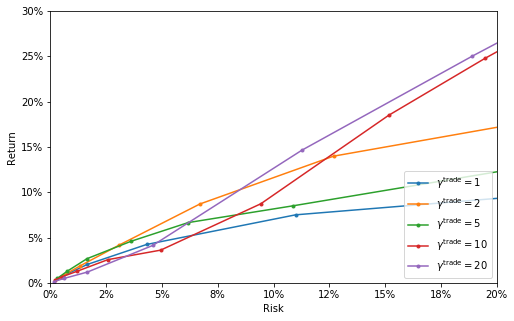

In [15]:
plt.figure(figsize=(8,5))
for gamma_tcost in result_df.columns:
    x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df[gamma_tcost]]
    y=[el.excess_returns.mean()*100*250 for el in result_df[gamma_tcost]]
    print(x,y)
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,20])
plt.ylim([0,30])


import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

plt.savefig(plotdir+'spo_riskrewardfrontier.png')

### Fine Search

In [16]:
policies = {}
gamma_risks_fine=gamma_risks_coarse
gamma_tcosts_fine=[4,5,6,7,8]
for gamma_risk in gamma_risks_fine:
    for gamma_tcost in gamma_tcosts_fine: 
        risk_model = helium.BasicRiskCost(gamma_risk, Sigma_hat)
        optimization_hcost = helium.HoldingCost(gamma = 1., borrow_costs=borrow_costs, dividends=dividends)
        optimization_tcost = helium.TransactionCost(gamma_tcost, 
                                                    half_spread=0.0005/2., 
                                                    nonlin_coef = 1.,
                                                    sigmas = sigma_estimate, 
                                                    nonlin_power = 1.5,
                                                    volumes = volume_estimate,
                                                    asym_coef = 0.)
        
        # issue optimization_tcost
        costs = [
            risk_model, 
                 optimization_tcost, 
                 optimization_hcost
                ]
        const = [helium.LeverageLimitConstraint(3)]
        policies[(gamma_risk, gamma_tcost)] = helium.SinglePeriodOpt(r, costs, const)

In [17]:
results.update(dict(zip(policies.keys(), simulator.run_multi(1E8*w_b, policies.values(), start_date, end_date, parallel=True ) ) ) )

In [18]:
result_df_fine=pd.DataFrame()
for k in results:
    if k[0] in gamma_risks_fine and k[1] in list(gamma_tcosts_fine):
        result_df_fine.loc[k[0], k[1]] = results[k]
        
result_df_fine=result_df_fine.loc[sorted(result_df_fine.index),sorted(result_df_fine.columns)]

[38.344722076340453, 33.9053340448922, 22.199634752623425, 12.835686082480127, 7.5393945677107297, 4.1772238660027687, 1.9003812097348209, 0.89466664841902566, 0.36600407620772124] [37.8595452832858, 28.70844654395253, 16.97071107041465, 11.554715792354045, 8.161805028459971, 5.830214543443041, 3.1297498925295004, 1.4742628819941683, 0.561045676575541]
[36.263973936110581, 31.763097269781056, 20.164450144942549, 10.862545029848782, 6.1760198051288588, 3.6255322248540023, 1.6443757710962517, 0.75848509484417292, 0.32079695721875556] [36.12521931393052, 27.8154957625391, 12.317329433312574, 8.493092315971845, 6.6465082269427604, 4.591467332774057, 2.663442043224656, 1.2806052480037105, 0.49901044065000794]
[31.653270516417514, 27.659508895336067, 18.321063686533101, 9.9658653299979303, 5.3260224115353676, 3.2020398307493556, 1.4823511262548563, 0.66725264717313093, 0.28262905097503543] [31.72210990029542, 24.574586637202835, 11.610420369926901, 6.685192927478471, 5.658275600947744, 3.727

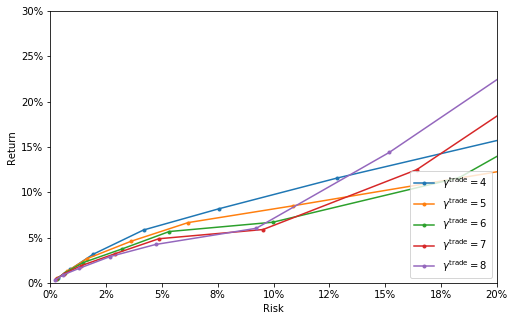

In [19]:
plt.figure(figsize=(8,5))
for gamma_tcost in result_df_fine.columns[:]:
    x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df_fine[gamma_tcost]]
    y=[el.excess_returns.mean()*100*250 for el in result_df_fine[gamma_tcost]]
    print(x,y)
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,20])
plt.ylim([0,30])


import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'spo_riskrewardfrontier_fine.png')

### Pareto

In [25]:
results_pareto={}

In [26]:
policies = {}
#results = {}
gamma_risks_pareto=[0.1, 0.17782, 0.31624, 0.562, 1.0, 2, 3, 6, 10, 18, 32, 56, 100, 178, 316, 562, 1000]
gamma_tcosts_pareto=[5.5,6,6.5,7,7.5,8]
gamma_holdings=[.1,1.,10.,100., 1000.]
for gamma_risk in gamma_risks_pareto:
    for gamma_tcost in gamma_tcosts_pareto : 
        for gamma_holding in gamma_holdings:
            risk_model = helium.BasicRiskCost(gamma_risk, Sigma_hat)
            optimization_hcost = helium.HoldingCost(gamma_holding , borrow_costs=borrow_costs, dividends=dividends)
            optimization_tcost = helium.TransactionCost(gamma_tcost, 
                                                    half_spread=0.0005/2., 
                                                    nonlin_coef = 1.,
                                                    sigmas = sigma_estimate, 
                                                    nonlin_power = 1.5,
                                                    volumes = volume_estimate,
                                                    asym_coef = 0.)
        
            # issue optimization_tcost

            costs = [risk_model,    optimization_tcost,                  optimization_hcost  ]
            const = [helium.LeverageLimitConstraint(3)]
            policies[(gamma_risk, gamma_tcost, gamma_holding)] = helium.SinglePeriodOpt(r, costs, const)

In [27]:
results_pareto.update(dict(zip(policies.keys(), simulator.run_multi(1E8*w_b, policies.values(), start_date, end_date, parallel=True ) ) ) )

In [42]:
table=pd.DataFrame()
table[r'$\gamma^\mathrm{risk}$']=[el[0] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{trade}$']=[el[1] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{hold}$']=['%g'%el[2] for el in results_pareto.keys()]
table['Return']=[(results_pareto[k].excess_returns.mean()*100*250) for k in results_pareto.keys()]
table['Risk']=[(results_pareto[k].excess_returns.std()*100*np.sqrt(250)) for k in results_pareto.keys()]
table = table.sort_values('Risk', ascending=False).reset_index()
del table['index']
is_pareto = lambda i: table.loc[i,'Return']>=max(table.ix[i:].Return)
table['is_pareto'] = [is_pareto(i) for i in range(len(table))]
table.to_csv(datadir+'spo_pareto_results.csv', float_format='%g')

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


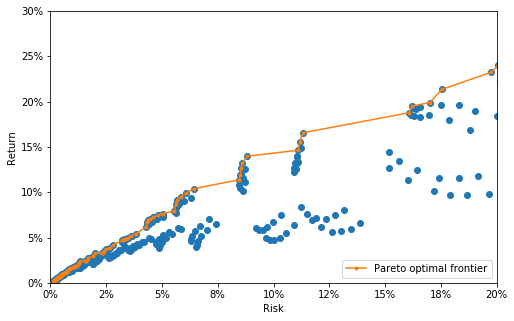

In [43]:
plt.figure(figsize=(8,5))
plt.scatter(table.Risk.values,table.Return.values)
plt.plot(table[table.is_pareto].Risk,table[table.is_pareto].Return, 'C1.-', label='Pareto optimal frontier')
plt.legend( loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,20])
plt.ylim([0,30])

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'spo_pareto.png')

In [44]:
table

,$\gamma^\mathrm{risk}$,$\gamma^\mathrm{trade}$,$\gamma^\mathrm{hold}$,Return,Risk,is_pareto
0,0.10000,5.5,100,40.749019,35.780799,True
1,0.10000,5.5,10,39.590149,35.678077,True
2,0.10000,5.5,0.1,32.250067,35.496627,False
3,0.10000,5.5,1,34.222294,35.341548,False
4,0.17782,5.5,100,38.624997,34.091910,True
5,0.17782,5.5,0.1,29.212984,33.851867,False
6,0.17782,5.5,10,37.286340,33.779776,False
7,0.17782,5.5,1,31.599016,33.778826,False
8,0.10000,6.0,100,38.539498,33.707268,True
9,0.10000,6.0,10,37.419400,33.423215,True


In [46]:
xlim=20
ylim=30
table=table[table.is_pareto]
table=table[table.Risk <= xlim]
table=table[table.Return <= ylim]
del table['is_pareto']
table.Risk=table.Risk.apply(lambda x: '%.2f%%'%x)
table.Return=table.Return.apply(lambda x: '%.2f%%'%x)
print(table.iloc[::-1].to_latex(float_format='%.2f', escape=False, index=False).replace('%',r'\%'))

\begin{tabular}{rrlll}
\toprule
 $\gamma^\mathrm{risk}$ &  $\gamma^\mathrm{trade}$ & $\gamma^\mathrm{hold}$ &  Return &    Risk \\
\midrule
                1000.00 &                      8.0 &                    100 &   0.22\% &   0.15\% \\
                1000.00 &                      7.5 &                    100 &   0.23\% &   0.16\% \\
                1000.00 &                      7.0 &                    100 &   0.24\% &   0.17\% \\
                1000.00 &                      6.5 &                    100 &   0.26\% &   0.18\% \\
                1000.00 &                      6.0 &                    100 &   0.27\% &   0.18\% \\
                1000.00 &                      5.5 &                    100 &   0.29\% &   0.19\% \\
                1000.00 &                      8.0 &                     10 &   0.32\% &   0.20\% \\
                1000.00 &                      7.5 &                     10 &   0.34\% &   0.21\% \\
                1000.00 &                      7.0 &

In [47]:
table

,$\gamma^\mathrm{risk}$,$\gamma^\mathrm{trade}$,$\gamma^\mathrm{hold}$,Return,Risk
91,0.562,8.0,10,23.24%,19.76%
101,1.000,5.5,100,21.36%,17.56%
105,1.000,6.0,100,19.90%,16.99%
113,1.000,8.0,100,19.49%,16.20%
115,1.000,8.0,10,18.77%,16.06%
131,2.000,5.5,100,16.56%,11.33%
134,2.000,6.0,100,15.57%,11.17%
135,2.000,6.5,100,14.63%,11.10%
156,3.000,5.5,100,13.97%,8.82%
161,3.000,6.0,100,13.20%,8.61%
